In [56]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

In [57]:
class PCA:

    def __init__(self):
        self.alpha_ = None
        self.D2_ = None
        self.DH2_ = None
        self.bound_ = None

    def fit(self, sample1, sample2):
        n1, n2 = sample1.shape[0], sample2.shape[0]
        n_features = sample1.shape[1]
        
        mean1 = np.mean(sample1, axis=0)
        mean2 = np.mean(sample2, axis=0)

        cov1 = np.cov(sample1, rowvar=False)
        cov2 = np.cov(sample2, rowvar=False)

        covariance_matrix = (1.0 / (n1 + n2 - 2)) * ((n1 - 1) * cov1 + (n2 - 1) * cov2)

        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        self.alpha_ = np.dot(mean1 - mean2, inv_covariance_matrix)

        z1 = np.dot(sample1, self.alpha_)
        z2 = np.dot(sample2, self.alpha_)

        z1_mean = np.mean(z1)
        z2_mean = np.mean(z2)

        z_var = np.dot(self.alpha_.T, np.dot(covariance_matrix, self.alpha_))
        
        self.D2_ = (z1_mean - z2_mean) ** 2 / z_var
        self.DH2_ = (n1 + n2 - n_features - 3) * self.D2_ / (n1 + n2 - 2) - n_features * (1 / n1 + 1 / n2)

        K = np.log(n2 / n1)
        F = lambda x : norm.cdf(x)
        
        self.P21_ = F(( K - 0.5 * self.DH2_) / np.sqrt(self.DH2_))
        self.P12_ = F(( -K - 0.5 * self.DH2_) / np.sqrt(self.DH2_))

        self.bound_ = (z1_mean + z2_mean) / 2 + K

    def transform(self, X):
        if self.alpha_ is None:
            raise RuntimeError("PCA is not fitted yet. Call fit() before transform.")
        
        return np.dot(X, self.alpha_)

    def predict(self, X):
        if self.alpha_ is None:
            raise RuntimeError("PCA is not fitted yet. Call fit() before predict.")
        
        return np.dot(X, self.alpha_) < self.bound_
    

In [58]:
def confusion_matrix(predictions, true_values):
    cm = np.zeros((2, 2), dtype=int)
    cm[0, 0] = np.sum(predictions[true_values == 0] == 0)
    cm[0, 1] = np.sum(predictions[true_values == 0] == 1)
    cm[1, 0] = np.sum(predictions[true_values == 1] == 0)
    cm[1, 1] = np.sum(predictions[true_values == 1] == 1)
    return cm

def plot_confusion_matrix(cm, ax):
    ax.imshow(cm, cmap='coolwarm', interpolation='nearest')
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['1', '2'])
    ax.set_yticklabels(['1', '2'])
    for (i, j), val in np.ndenumerate(cm):
        ax.text(j, i, f'{val}', ha='center', va='center', color='black')

def plot_3d_scatter(X, predictions, ax):
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=predictions, cmap='coolwarm', alpha=0.5)
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_zlabel('X3')


In [59]:
mean1 = np.array([1 ,2 ,3])
mean2 = np.array([3 ,2 ,1])
cov = np.matrix([[0.25 , 0.2 , 0.1], [0.2 , 0.64 , 0.15], [0.1 , 0.15 , 0.09]])

trainset1 = np.random.multivariate_normal(mean1, cov, 650)
trainset2 = np.random.multivariate_normal(mean2, cov, 350)

trainset = np.vstack((trainset1, trainset2))
true_values = np.hstack((np.zeros(trainset1.shape[0]), np.ones(trainset2.shape[0])))

testset1 = np.random.multivariate_normal(mean1, cov, 650)
testset2 = np.random.multivariate_normal(mean2, cov, 350)

testset = np.vstack((testset1, testset2))
test_true_values = np.hstack((np.zeros(testset1.shape[0]), np.ones(testset2.shape[0])))

Точность на обучающей выборке: 100.00%
Оценки расстояния Махаланобиса:
  смещенная D² = 192.82412589820936
  несмещенная DH² = 192.03809689705378
Оценки вероятности ошибочной классификации (2):
  P(2|1) = 1.5450821253972871e-12
  P(1|2) = 2.9052576230995137e-12
Эмпирические оценки вероятности ошибочной классификации (1):
  Ṗ(2|1) = 0.0
  Ṗ(1|2) = 0.0


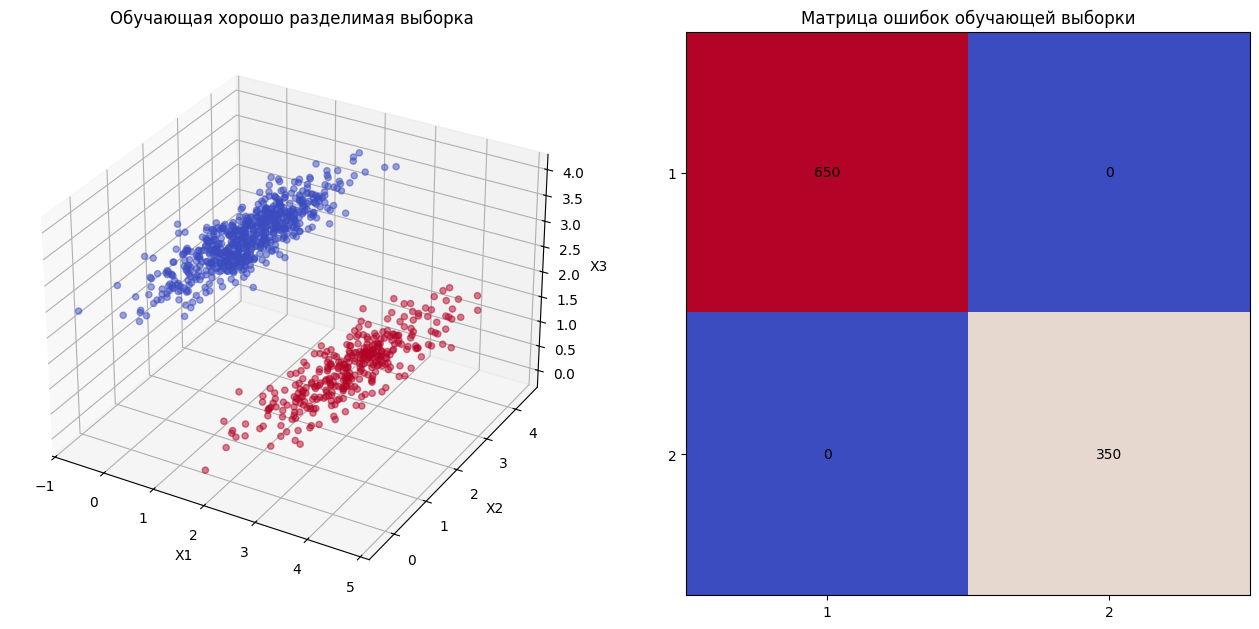

In [60]:
# Обучающая хорошо разделимая выборка
pca_good = PCA()
pca_good.fit(trainset1, trainset2)

predictions_good = pca_good.predict(trainset)
accuracy_good = np.mean(predictions_good == true_values)
cm = confusion_matrix(predictions_good, true_values)

P21 = cm[0, 1] / (cm[0, 0] + cm[0, 1])
P12 = cm[1, 0] / (cm[1, 0] + cm[1, 1])

print(f"Точность на обучающей выборке: {accuracy_good * 100:.2f}%")
print(f"Оценки расстояния Махаланобиса:\n  смещенная D² = {pca_good.D2_}\n  несмещенная DH² = {pca_good.DH2_}")
print(f"Оценки вероятности ошибочной классификации (2):\n  P(2|1) = {pca_good.P21_}\n  P(1|2) = {pca_good.P12_}")
print(f"Эмпирические оценки вероятности ошибочной классификации (1):\n  Ṗ(2|1) = {P21}\n  Ṗ(1|2) = {P12}")

fig = plt.figure(figsize =(16, 8))

ax = fig.add_subplot(1, 2, 1, projection = '3d')
ax.set_title('Обучающая хорошо разделимая выборка')
plot_3d_scatter(trainset, predictions_good, ax)

ax = fig.add_subplot(1, 2, 2)
ax.set_title('Матрица ошибок обучающей выборки')
plot_confusion_matrix(cm, ax)
    
plt.show()

Точность на тестовой выборке: 100.00%
Эмпирические оценки ошибочной классификации (1):
  Ṗ(2|1) = 0.0
  Ṗ(1|2) = 0.0


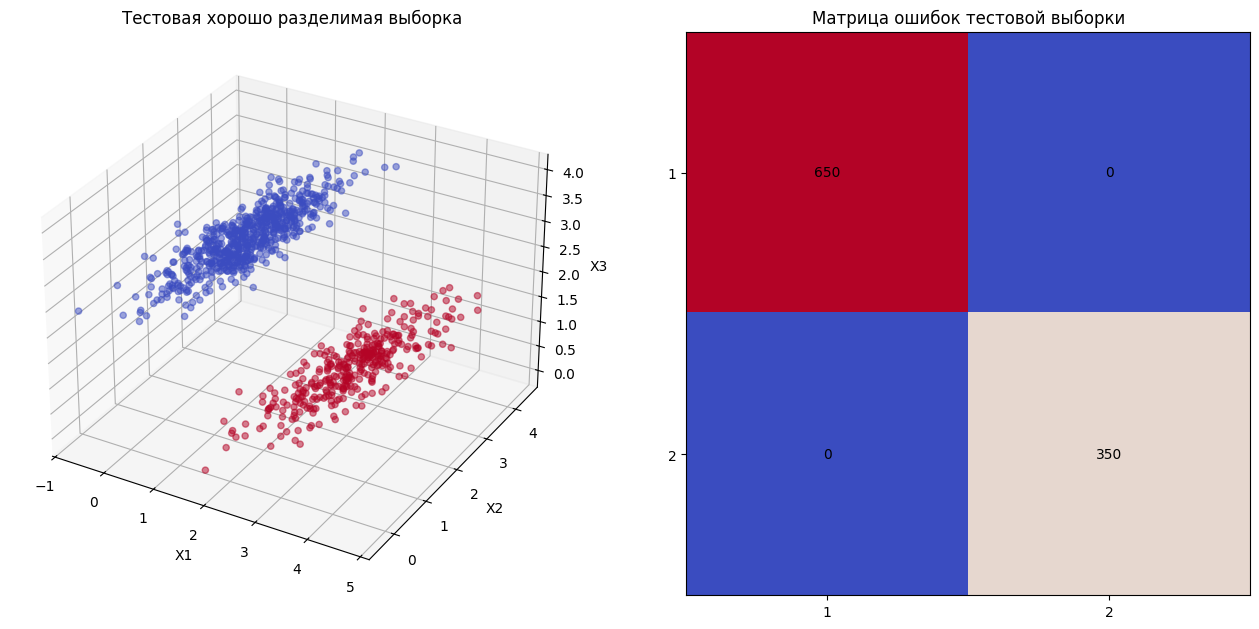

In [61]:
# Тестовая хорошо разделимая выборка
predictions_good_test = pca_good.predict(testset)
accuracy_good_test = np.mean(predictions_good_test == test_true_values)
cm = confusion_matrix(predictions_good_test, test_true_values)

P21 = cm[0, 1] / (cm[0, 0] + cm[0, 1])
P12 = cm[1, 0] / (cm[1, 0] + cm[1, 1])

print(f"Точность на тестовой выборке: {accuracy_good_test * 100:.2f}%")
print(f"Эмпирические оценки ошибочной классификации (1):\n  Ṗ(2|1) = {P21}\n  Ṗ(1|2) = {P12}")

fig = plt.figure(figsize =(16, 8))

ax = fig.add_subplot(1, 2, 1, projection = '3d')
ax.set_title('Тестовая хорошо разделимая выборка')
plot_3d_scatter(trainset, predictions_good, ax)

ax = fig.add_subplot(1, 2, 2)
ax.set_title('Матрица ошибок тестовой выборки')
plot_confusion_matrix(cm, ax)
    
plt.show()

In [62]:
cov_bad = (cov + 2) * 20

trainset1_bad = np.random.multivariate_normal(mean1, cov_bad, 650)
trainset2_bad = np.random.multivariate_normal(mean2, cov_bad, 350)

trainset_bad = np.vstack((trainset1_bad, trainset2_bad))
true_values_bad = np.hstack((np.zeros(trainset1_bad.shape[0]), np.ones(trainset2_bad.shape[0])))

testset1_bad = np.random.multivariate_normal(mean1, cov_bad, 650)
testset2_bad = np.random.multivariate_normal(mean2, cov_bad, 350)

testset_bad = np.vstack((testset1_bad, testset2_bad))
test_true_values_bad = np.hstack((np.zeros(testset1_bad.shape[0]), np.ones(testset2_bad.shape[0])))

Точность на обучающей выборке: 90.20%
Оценки расстояния Махаланобиса:
  смещенная D² = 6.102655584735244
  несмещенная DH² = 6.0650092301266465
Оценки вероятности ошибочной классификации (2):
  P(2|1) = 0.06907366592844401
  P(1|2) = 0.16354346617459065
Эмпирические оценки вероятности ошибочной классификации (1):
  Ṗ(2|1) = 0.06461538461538462
  Ṗ(1|2) = 0.16


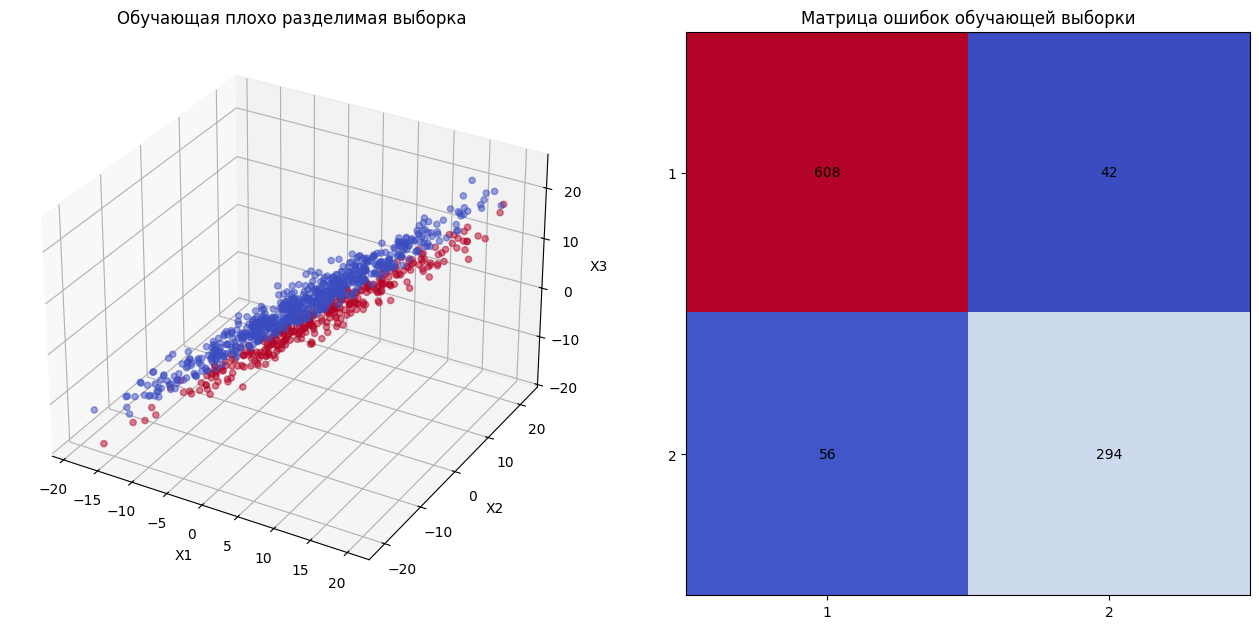

In [68]:
# Обучающая плохо разделимая выборка
pca_bad = PCA()
pca_bad.fit(trainset1_bad, trainset2_bad)

predictions_bad = pca_bad.predict(trainset_bad)
accuracy_bad = np.mean(predictions_bad == true_values_bad)
cm = confusion_matrix(predictions_bad, true_values_bad)

P21 = cm[0, 1] / (cm[0, 0] + cm[0, 1])
P12 = cm[1, 0] / (cm[1, 0] + cm[1, 1])

print(f"Точность на обучающей выборке: {accuracy_bad * 100:.2f}%")
print(f"Оценки расстояния Махаланобиса:\n  смещенная D² = {pca_bad.D2_}\n  несмещенная DH² = {pca_bad.DH2_}")
print(f"Оценки вероятности ошибочной классификации (2):\n  P(2|1) = {pca_bad.P21_}\n  P(1|2) = {pca_bad.P12_}")
print(f"Эмпирические оценки вероятности ошибочной классификации (1):\n  Ṗ(2|1) = {P21}\n  Ṗ(1|2) = {P12}")

fig = plt.figure(figsize =(16, 8))

ax = fig.add_subplot(1, 2, 1, projection = '3d')
ax.set_title('Обучающая плохо разделимая выборка')
plot_3d_scatter(trainset_bad, predictions_bad, ax)

ax = fig.add_subplot(1, 2, 2)
ax.set_title('Матрица ошибок обучающей выборки')
plot_confusion_matrix(cm, ax)
    
plt.show()

Точность на тестовой выборке: 90.90%
Эмпирические оценки ошибочной классификации (1):
  Ṗ(2|1) = 0.06153846153846154
  Ṗ(1|2) = 0.1457142857142857


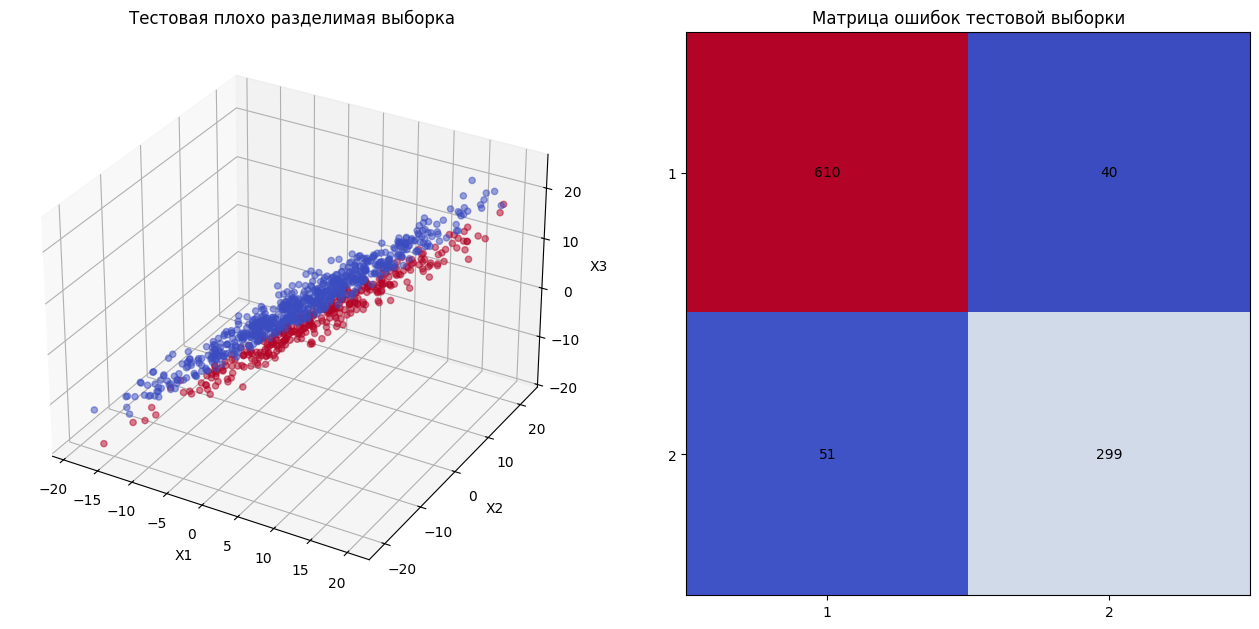

In [69]:
# Тестовая плохо разделимая выборка
predictions_bad_test = pca_bad.predict(testset_bad)
accuracy_bad_test = np.mean(predictions_bad_test == test_true_values_bad)
cm = confusion_matrix(predictions_bad_test, test_true_values_bad)

P21 = cm[0, 1] / (cm[0, 0] + cm[0, 1])
P12 = cm[1, 0] / (cm[1, 0] + cm[1, 1])

print(f"Точность на тестовой выборке: {accuracy_bad_test * 100:.2f}%")
print(f"Эмпирические оценки ошибочной классификации (1):\n  Ṗ(2|1) = {P21}\n  Ṗ(1|2) = {P12}")

fig = plt.figure(figsize =(16, 8))

ax = fig.add_subplot(1, 2, 1, projection = '3d')
ax.set_title('Тестовая плохо разделимая выборка')
plot_3d_scatter(trainset_bad, predictions_bad, ax)

ax = fig.add_subplot(1, 2, 2)
ax.set_title('Матрица ошибок тестовой выборки')
plot_confusion_matrix(cm, ax)
    
plt.show()

In [65]:
# Данные из репозитария
X, Y = [], []
with open("german.data-numeric") as data:
    for string in data:
        string = string.split()
        x, y = string[:-1], string[-1]
        X.append(np.array(list(map(lambda elem: float(elem), x))))
        Y.append(int(y) - 1)
X = np.array(X)
Y = np.array(Y)

X1 = X[Y == 0]
X2 = X[Y == 1]
n1 = len(X1)
n2 = len(X2)

train_coefficient = 0.8

train_size1 = int(train_coefficient * n1)
train_size2 = int(train_coefficient * n2)

trainset1_rep = X1[:train_size1]
trainset2_rep = X2[:train_size2]

trainset_rep = np.vstack((trainset1_rep, trainset2_rep))
true_values_rep = np.hstack((np.zeros(trainset1_rep.shape[0]), np.ones(trainset2_rep.shape[0])))

testset1_rep = X1[train_size1:]
testset2_rep = X2[train_size2:]

testset_rep = np.vstack((testset1_rep, testset2_rep))
test_true_values_rep = np.hstack((np.zeros(testset1_rep.shape[0]), np.ones(testset2_rep.shape[0])))

Точность на обучающей выборке: 78.62%
Оценки расстояния Махаланобиса:
  смещенная D² = 1.5869360988805263
  несмещенная DH² = 1.394362912825372
Оценки вероятности ошибочной классификации (2):
  P(2|1) = 0.09544358008250303
  P(1|2) = 0.5505803419744394
Эмпирические оценки вероятности ошибочной классификации (1):
  Ṗ(2|1) = 0.10535714285714286
  Ṗ(1|2) = 0.4666666666666667


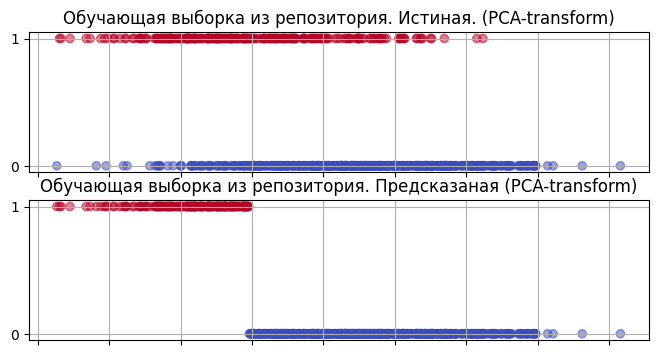

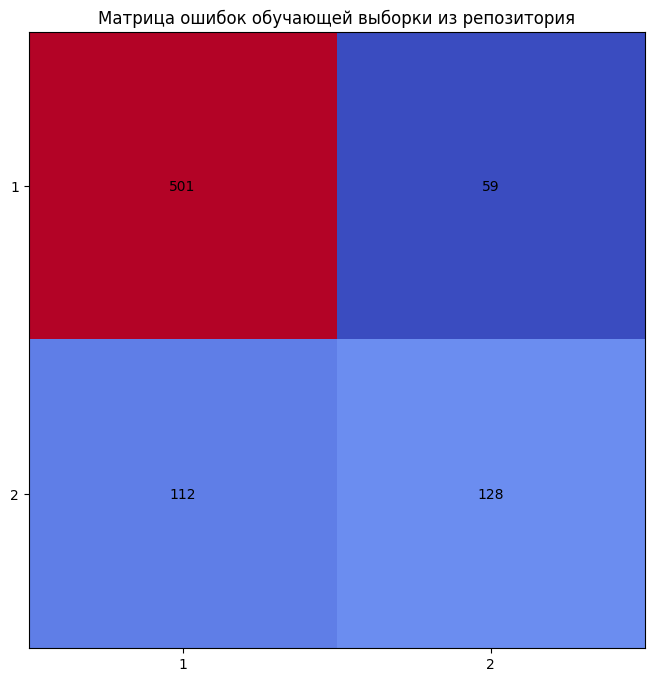

In [66]:
# Обучающая выборка из репозитория
pca_rep = PCA()
pca_rep.fit(trainset1_rep, trainset2_rep)

z_rep = pca_rep.transform(trainset_rep)
predictions_rep = pca_rep.predict(trainset_rep)
accuracy_rep = np.mean(predictions_rep == true_values_rep)
cm = confusion_matrix(predictions_rep, true_values_rep)

P21 = cm[0, 1] / (cm[0, 0] + cm[0, 1])
P12 = cm[1, 0] / (cm[1, 0] + cm[1, 1])

print(f"Точность на обучающей выборке: {accuracy_rep * 100:.2f}%")
print(f"Оценки расстояния Махаланобиса:\n  смещенная D² = {pca_rep.D2_}\n  несмещенная DH² = {pca_rep.DH2_}")
print(f"Оценки вероятности ошибочной классификации (2):\n  P(2|1) = {pca_rep.P21_}\n  P(1|2) = {pca_rep.P12_}")
print(f"Эмпирические оценки вероятности ошибочной классификации (1):\n  Ṗ(2|1) = {P21}\n  Ṗ(1|2) = {P12}")

fig1 = plt.figure(figsize =(8, 4))

ax = fig1.add_subplot(2, 1, 1)
ax.grid()
ax.set_title('Обучающая выборка из репозитория. Истиная. (PCA-transform)')
ax.scatter(z_rep, true_values_rep, c=true_values_rep, cmap='coolwarm', alpha=0.5)
ax.set_xticklabels([])
ax.set_yticks([0, 1])
ax.set_yticklabels(['0', '1'])

ax = fig1.add_subplot(2, 1, 2)
ax.grid()
ax.set_title('Обучающая выборка из репозитория. Предсказаная (PCA-transform)')
ax.scatter(z_rep, predictions_rep, c=predictions_rep, cmap='coolwarm', alpha=0.5)
ax.set_xticklabels([])
ax.set_yticks([0, 1])
ax.set_yticklabels(['0','1'])

fig2 = plt.figure(figsize =(8, 8)) 
ax = fig2.add_subplot(1, 1, 1)
ax.set_title('Матрица ошибок обучающей выборки из репозитория')
plot_confusion_matrix(cm, ax)

plt.show()

Точность на тестовой выборке: 78.50%
Эмпирические оценки ошибочной классификации (1):
  Ṗ(2|1) = 0.12142857142857143
  Ṗ(1|2) = 0.43333333333333335


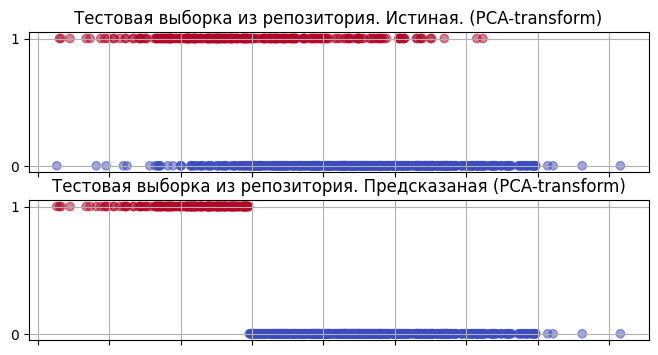

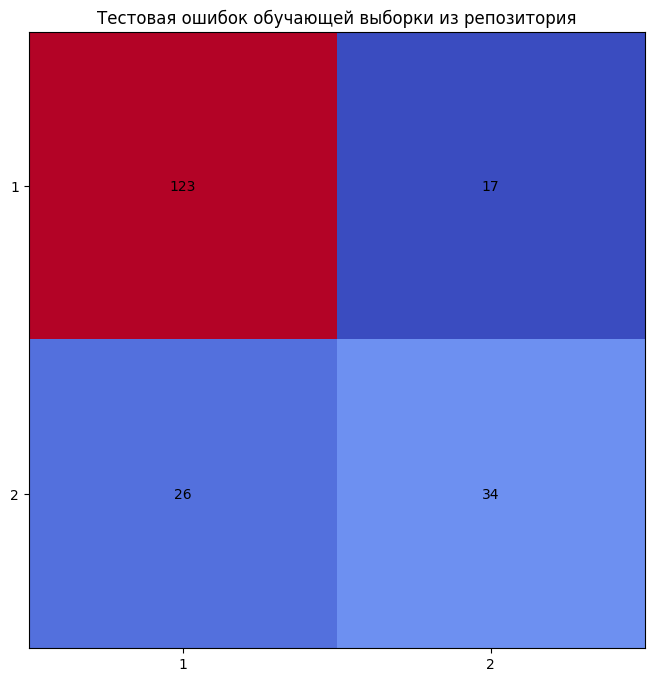

In [67]:
# Тестовая плохо разделимая выборка
z_rep_test = pca_rep.transform(trainset_rep)
predictions_rep_test = pca_rep.predict(testset_rep)
accuracy_rep_test = np.mean(predictions_rep_test == test_true_values_rep)
cm = confusion_matrix(predictions_rep_test, test_true_values_rep)

P21 = cm[0, 1] / (cm[0, 0] + cm[0, 1])
P12 = cm[1, 0] / (cm[1, 0] + cm[1, 1])

print(f"Точность на тестовой выборке: {accuracy_rep_test * 100:.2f}%")
print(f"Эмпирические оценки ошибочной классификации (1):\n  Ṗ(2|1) = {P21}\n  Ṗ(1|2) = {P12}")

fig1 = plt.figure(figsize =(8, 4))

ax = fig1.add_subplot(2, 1, 1)
ax.grid()
ax.set_title('Тестовая выборка из репозитория. Истиная. (PCA-transform)')
ax.scatter(z_rep, true_values_rep, c=true_values_rep, cmap='coolwarm', alpha=0.5)
ax.set_xticklabels([])
ax.set_yticks([0, 1])
ax.set_yticklabels(['0', '1'])

ax = fig1.add_subplot(2, 1, 2)
ax.grid()
ax.set_title('Тестовая выборка из репозитория. Предсказаная (PCA-transform)')
ax.scatter(z_rep, predictions_rep, c=predictions_rep, cmap='coolwarm', alpha=0.5)
ax.set_xticklabels([])
ax.set_yticks([0, 1])
ax.set_yticklabels(['0','1'])

fig2 = plt.figure(figsize =(8, 8)) 
ax = fig2.add_subplot(1, 1, 1)
ax.set_title('Тестовая ошибок обучающей выборки из репозитория')
plot_confusion_matrix(cm, ax)

plt.show()